In [1]:
from glob import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
from scipy.stats import spearmanr
from sklearn.linear_model import Lasso

## Load data

In [2]:
# Get Chatbot Arena
chatbot_arena_files = glob('data/chatbot-arena-leaderboard/*.csv')
chatbot_arena_files.sort(key=lambda x: int(x[-12:-4]))
# Head: key,Model,MT-bench (score),MMLU,License,Organization,Link
chatbot_arena = pd.read_csv(chatbot_arena_files[-1], sep=',', header=0)

chatbot_arena_elo_files = glob('data/chatbot-arena-leaderboard/*.pkl')
chatbot_arena_elo_files.sort(key=lambda x: int(x[-12:-4]))
chatbot_arena_elo = pickle.load(open(chatbot_arena_elo_files[-1], 'rb'))

# Use elo as ground truth
elo = chatbot_arena_elo['leaderboard_table_df']

In [3]:
chatbot_arena

,key,Model,MT-bench (score),MMLU,License,Organization,Link
0,wizardlm-30b,WizardLM-30B,7.01,0.587,Non-commercial,Microsoft,https://huggingface.co/WizardLM/WizardLM-30B-V1.0
1,vicuna-13b-16k,Vicuna-13B-16k,6.92,0.545,Llama 2 Community,LMSYS,https://huggingface.co/lmsys/vicuna-13b-v1.5-16k
2,wizardlm-13b-v1.1,WizardLM-13B-v1.1,6.76,0.500,Non-commercial,Microsoft,https://huggingface.co/WizardLM/WizardLM-13B-V1.1
3,tulu-30b,Tulu-30B,6.43,0.581,Non-commercial,AllenAI/UW,https://huggingface.co/allenai/tulu-30b
4,guanaco-65b,Guanaco-65B,6.41,0.621,Non-commercial,UW,https://huggingface.co/timdettmers/guanaco-65b...
...,...,...,...,...,...,...,...
63,stablelm-tuned-alpha-7b,StableLM-Tuned-Alpha-7B,2.75,0.244,CC-BY-NC-SA-4.0,Stability AI,https://huggingface.co/stabilityai/stablelm-tu...
64,dolly-v2-12b,Dolly-V2-12B,3.28,0.257,MIT,Databricks,https://huggingface.co/databricks/dolly-v2-12b
65,llama-13b,LLaMA-13B,2.61,0.470,Non-commercial,Meta,https://arxiv.org/abs/2302.13971
66,mistral-medium,Mistral Medium,8.61,0.753,Proprietary,Mistral,https://mistral.ai/news/la-plateforme/


In [4]:
# Get Alpaca Eval
# Head: name,win_rate,avg_length,link,samples,filter
alpaca_eval = pd.read_csv('data/alpaca_eval_gpt4_leaderboard.csv', sep=',', header=0)

In [5]:
alpaca_eval

,name,win_rate,avg_length,link,samples,filter
0,GPT-4 Turbo,97.699005,2049,NaN,https://github.com/tatsu-lab/alpaca_eval/blob/...,minimal
1,XwinLM 70b V0.1,95.568040,1775,https://github.com/Xwin-LM/Xwin-LM,https://github.com/tatsu-lab/alpaca_eval/blob/...,community
2,PairRM+Tulu 2+DPO 70B (best-of-16),95.398010,1607,https://huggingface.co/llm-blender/PairRM,https://github.com/tatsu-lab/alpaca_eval/blob/...,community
3,GPT-4,95.279503,1365,NaN,https://github.com/tatsu-lab/alpaca_eval/blob/...,minimal
4,Tulu 2+DPO 70B,95.031056,1418,https://huggingface.co/allenai/tulu-2-dpo-70b,https://github.com/tatsu-lab/alpaca_eval/blob/...,community
...,...,...,...,...,...,...
92,Alpaca 7B,26.459627,396,https://huggingface.co/tatsu-lab/alpaca-7b-wdiff,https://github.com/tatsu-lab/alpaca_eval/blob/...,minimal
93,Pythia 12B OASST SFT,25.962733,726,https://huggingface.co/OpenAssistant/oasst-sft...,https://github.com/tatsu-lab/alpaca_eval/blob/...,verified
94,Falcon 7B Instruct,23.602484,478,https://huggingface.co/tiiuae/falcon-7b-instruct,https://github.com/tatsu-lab/alpaca_eval/blob/...,verified
95,Baichuan-13B-Chat,21.801242,1727,https://huggingface.co/baichuan-inc/Baichuan-1...,https://github.com/tatsu-lab/alpaca_eval/blob/...,community


In [6]:
# Number of lines in elo
len(elo)

54

In [7]:
elo

,rating,variance,rating_q975,rating_q025,num_battles
RWKV-4-Raven-14B,924.231727,56.102110,939.938277,910.571472,5231
alpaca-13b,903.741314,48.294819,918.853719,890.549086,6206
chatglm-6b,882.464210,52.359596,896.432612,868.335295,5266
chatglm2-6b,928.856627,73.475978,946.275697,913.007148,2924
chatglm3-6b,959.975825,66.490085,977.777208,945.182976,3696
claude-1,1149.379341,47.590691,1164.315198,1136.601676,16956
claude-2.0,1130.616704,52.432423,1145.070539,1117.537633,11204
claude-2.1,1118.772077,46.599912,1133.145271,1106.276687,20883
claude-instant-1,1109.380031,47.385636,1124.636944,1096.643598,16182
codellama-34b-instruct,1041.413340,51.029353,1057.412081,1029.251071,6464


## Filter out models with benchmark results

In [8]:
models = {}

for key in elo.index:
    if chatbot_arena.loc[chatbot_arena['key'] == key].empty:
        print(key)
    else:
        model = chatbot_arena.loc[chatbot_arena['key'] == key].iloc[0].to_dict()
        models[key] = model

In [9]:
hf_models = {}
for key in models.keys():
    if 'huggingface' in models[key]['Link']:
        hf_models[key] = models[key]

In [10]:
filtered_hf_models = {}

# Retrieve hf model results from open-llm-leaderboard
for key in hf_models.keys():
    link = hf_models[key]['Link']
    path = 'data/open-llm-leaderboard/' + '/'.join(link.split('/')[-2:])
    if os.path.exists(path):
        result_files = glob(path + '/*.json')
        results = {}
        for file in result_files:
            with open(file) as f:
                result = json.load(f)
                results |= result.get('results', {})

        filtered_hf_models[key] = hf_models[key]
        filtered_hf_models[key]['results'] = results

In [11]:
len(filtered_hf_models)

26

In [12]:
filtered_hf_models

{'chatglm2-6b': {'key': 'chatglm2-6b',
  'Model': 'ChatGLM2-6B',
  'MT-bench (score)': '4.96',
  'MMLU': '0.455',
  'License': 'Apache-2.0',
  'Organization': 'Tsinghua',
  'Link': 'https://huggingface.co/THUDM/chatglm2-6b',
  'results': {'harness|arc:challenge|25': {'acc': 0.37457337883959047,
    'acc_stderr': 0.014144193471893444,
    'acc_norm': 0.38822525597269625,
    'acc_norm_stderr': 0.014241614207414044},
   'harness|hellaswag|10': {'acc': 0.4596693885680143,
    'acc_stderr': 0.004973522582431221,
    'acc_norm': 0.5902210714997013,
    'acc_norm_stderr': 0.004907877144720029},
   'harness|hendrycksTest-abstract_algebra|5': {'acc': 0.28,
    'acc_stderr': 0.04512608598542128,
    'acc_norm': 0.28,
    'acc_norm_stderr': 0.04512608598542128},
   'harness|hendrycksTest-anatomy|5': {'acc': 0.4148148148148148,
    'acc_stderr': 0.042561937679014075,
    'acc_norm': 0.4148148148148148,
    'acc_norm_stderr': 0.042561937679014075},
   'harness|hendrycksTest-astronomy|5': {'acc': 0

In [13]:
results

{'harness|arc:challenge|25': {'acc': 0.590443686006826,
  'acc_stderr': 0.014370358632472437,
  'acc_norm': 0.6203071672354948,
  'acc_norm_stderr': 0.01418211986697487},
 'harness|hellaswag|10': {'acc': 0.6491734714200359,
  'acc_stderr': 0.004762534245488399,
  'acc_norm': 0.8435570603465445,
  'acc_norm_stderr': 0.003625323221166244},
 'harness|hendrycksTest-abstract_algebra|5': {'acc': 0.36,
  'acc_stderr': 0.04824181513244218,
  'acc_norm': 0.36,
  'acc_norm_stderr': 0.04824181513244218},
 'harness|hendrycksTest-anatomy|5': {'acc': 0.6074074074074074,
  'acc_stderr': 0.04218506215368881,
  'acc_norm': 0.6074074074074074,
  'acc_norm_stderr': 0.04218506215368881},
 'harness|hendrycksTest-astronomy|5': {'acc': 0.6052631578947368,
  'acc_stderr': 0.039777499346220734,
  'acc_norm': 0.6052631578947368,
  'acc_norm_stderr': 0.039777499346220734},
 'harness|hendrycksTest-business_ethics|5': {'acc': 0.56,
  'acc_stderr': 0.04988876515698589,
  'acc_norm': 0.56,
  'acc_norm_stderr': 0.049

In [14]:
benchmarks = []
for model in filtered_hf_models.values():
    benchmarks.append(list(model['results'].keys()))
    
# Intersection of benchmarks
common_benchmarks = benchmarks[0]
for benchmark in benchmarks:
    common_benchmarks = list(set(common_benchmarks) & set(benchmark))

In [15]:
common_benchmarks = [x for x in common_benchmarks if '|' in x]

In [16]:
filtered_hf_models

{'chatglm2-6b': {'key': 'chatglm2-6b',
  'Model': 'ChatGLM2-6B',
  'MT-bench (score)': '4.96',
  'MMLU': '0.455',
  'License': 'Apache-2.0',
  'Organization': 'Tsinghua',
  'Link': 'https://huggingface.co/THUDM/chatglm2-6b',
  'results': {'harness|arc:challenge|25': {'acc': 0.37457337883959047,
    'acc_stderr': 0.014144193471893444,
    'acc_norm': 0.38822525597269625,
    'acc_norm_stderr': 0.014241614207414044},
   'harness|hellaswag|10': {'acc': 0.4596693885680143,
    'acc_stderr': 0.004973522582431221,
    'acc_norm': 0.5902210714997013,
    'acc_norm_stderr': 0.004907877144720029},
   'harness|hendrycksTest-abstract_algebra|5': {'acc': 0.28,
    'acc_stderr': 0.04512608598542128,
    'acc_norm': 0.28,
    'acc_norm_stderr': 0.04512608598542128},
   'harness|hendrycksTest-anatomy|5': {'acc': 0.4148148148148148,
    'acc_stderr': 0.042561937679014075,
    'acc_norm': 0.4148148148148148,
    'acc_norm_stderr': 0.042561937679014075},
   'harness|hendrycksTest-astronomy|5': {'acc': 0

## Test correlation

In [17]:
# Check Spearman correlation between elo and each benchmark
corr_dict = {}

for benchmark in common_benchmarks:
    name = benchmark.split('|')[1]
    print(name)
    elo_scores = []
    benchmark_scores = []
    for model in filtered_hf_models:
        elo_scores.append(elo.loc[model]['rating'])
        result = filtered_hf_models[model]['results'][benchmark]
        if 'acc_norm' in result:
            benchmark_scores.append(result['acc_norm'])
        elif 'mc2' in result:
            benchmark_scores.append(result['mc2'])
    corr = spearmanr(elo_scores, benchmark_scores).correlation
    corr_dict[name] = corr

    print(corr)

hendrycksTest-high_school_statistics
0.7416547068048434
hendrycksTest-medical_genetics
0.6907544373283913
hendrycksTest-high_school_psychology
0.8345597578739297
hendrycksTest-moral_scenarios
0.7934990071790254
hendrycksTest-management
0.7924669152096665
hendrycksTest-college_mathematics
0.032663410259844795
hendrycksTest-high_school_computer_science
0.7871949080998777
hendrycksTest-astronomy
0.8248974490616756
hendrycksTest-high_school_world_history
0.8279754246178759
hendrycksTest-high_school_us_history
0.8240336380878359
hendrycksTest-marketing
0.8356734983682623
hendrycksTest-high_school_mathematics
0.6143861143657399
hendrycksTest-college_physics
0.703305063609025
hendrycksTest-high_school_european_history
0.8363264312738408
hendrycksTest-human_sexuality
0.7970572304932209
hendrycksTest-nutrition
0.79008547008547
hendrycksTest-professional_psychology
0.83775005498629
hendrycksTest-electrical_engineering
0.690623225047368
hendrycksTest-human_aging
0.8032844849915253
hendrycksTest-m

In [18]:
# Sort by correlation
corr_dict = {k: v for k, v in sorted(corr_dict.items(), key=lambda item: item[1], reverse=True)}

In [19]:
corr_dict

{'hendrycksTest-sociology': 0.870041090552613,
 'hendrycksTest-world_religions': 0.8464726206755547,
 'hendrycksTest-security_studies': 0.8449696445202932,
 'hendrycksTest-professional_psychology': 0.83775005498629,
 'hendrycksTest-high_school_government_and_politics': 0.8371538052701287,
 'hendrycksTest-high_school_european_history': 0.8363264312738408,
 'hendrycksTest-marketing': 0.8356734983682623,
 'hendrycksTest-high_school_psychology': 0.8345597578739297,
 'hendrycksTest-professional_law': 0.8345299145299144,
 'hendrycksTest-prehistory': 0.8343306670067543,
 'hendrycksTest-miscellaneous': 0.833646789410847,
 'hendrycksTest-logical_fallacies': 0.8309957470376553,
 'arc:challenge': 0.8290014164699427,
 'hendrycksTest-high_school_world_history': 0.8279754246178759,
 'hendrycksTest-astronomy': 0.8248974490616756,
 'hendrycksTest-high_school_us_history': 0.8240336380878359,
 'hendrycksTest-international_law': 0.8221007740351939,
 'hendrycksTest-college_biology': 0.8211541063054432,
 '

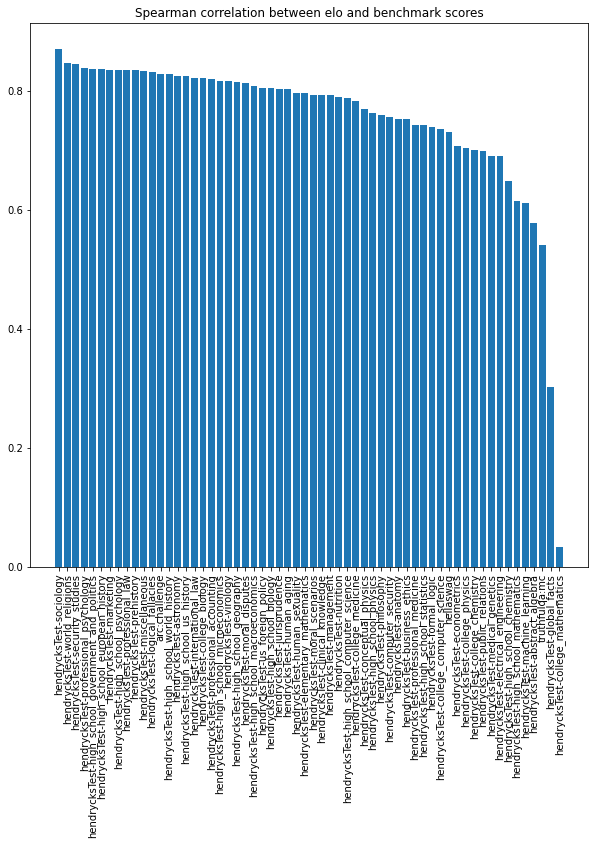

In [20]:
# Plot correlation
plt.figure(figsize=(10, 10))
plt.bar(corr_dict.keys(), corr_dict.values())
plt.xticks(rotation=90)
plt.title('Spearman correlation between elo and benchmark scores')
plt.show()

In [21]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(10, 10)})
sns.set(font_scale=1.5)

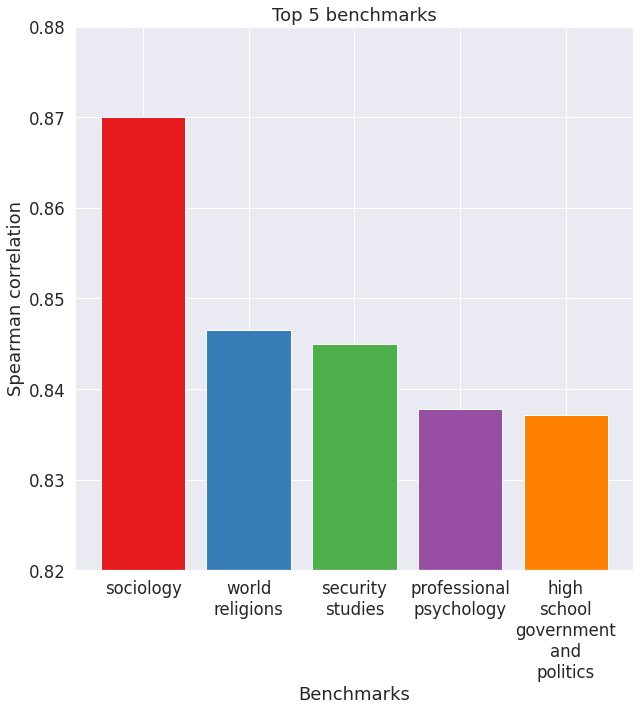

In [22]:
# Plot top 5 benchmarks and use different colors for each benchmark
plt.title('Top 5 benchmarks')
# plt.xticks(rotation=30)
plt.xlabel('Benchmarks')
plt.ylabel('Spearman correlation')
plt.ylim(0.82, 0.88)
for i, benchmark in enumerate(list(corr_dict.keys())[:5]):
    plt.bar(benchmark.replace("hendrycksTest-", "").replace("_", "\n"), corr_dict[benchmark], color=plt.cm.Set1(i))
plt.savefig('assets/top5_benchmarks.png')
plt.show()

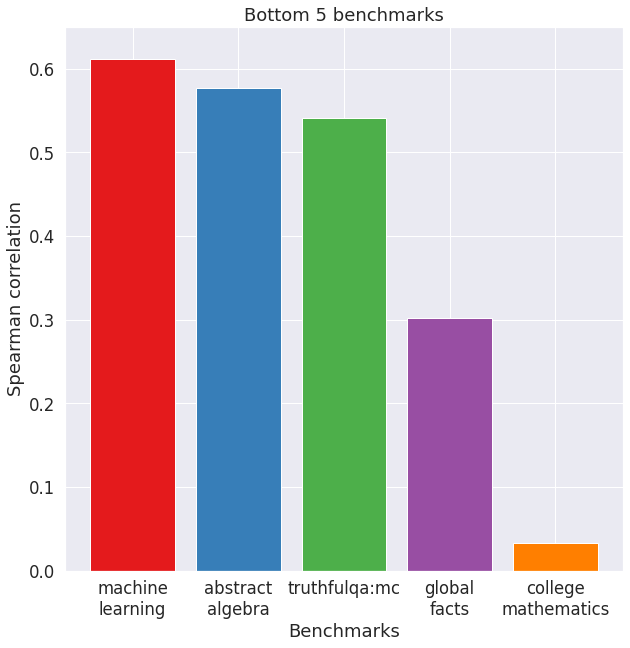

In [23]:
# Plot bottom 5 benchmarks and use different colors for each benchmark
plt.title('Bottom 5 benchmarks')
# plt.xticks(rotation=30)
plt.xlabel('Benchmarks')
plt.ylabel('Spearman correlation')
plt.ylim(0.0, 0.65)
for i, benchmark in enumerate(list(corr_dict.keys())[-5:]):
    plt.bar(benchmark.replace("hendrycksTest-", "").replace("_", "\n"), corr_dict[benchmark], color=plt.cm.Set1(i))
plt.savefig('assets/bottom5_benchmarks.png')
plt.show()

In [24]:
# Use LASSO to select benchmarks
X = []
y = []

for model in filtered_hf_models:
    x = []
    for benchmark in common_benchmarks:
        result = filtered_hf_models[model]['results'][benchmark]
        if 'acc_norm' in result:
            x.append(result['acc_norm'])
        elif 'mc2' in result:
            x.append(result['mc2'])

    X.append(x)
    y.append(elo.loc[model]['rating'])

In [25]:
X = np.array(X)
y = np.array(y)

# Randomly split into train and test
np.random.seed(0)
idx = np.random.permutation(len(X))
X_train = X[idx[:int(0.8 * len(X))]]
y_train = y[idx[:int(0.8 * len(X))]]
X_test = X[idx[int(0.8 * len(X)):]]
y_test = y[idx[int(0.8 * len(X)):]]

reg = Lasso(alpha=0.5, max_iter=10000)

reg.fit(X_train, y_train)

reg.score(X_test, y_test)

0.789712919150614

In [26]:
reg.coef_

array([  0.        ,   0.        ,  18.08683519,   0.        ,
         0.        ,  -0.        ,   0.        ,   0.        ,
         0.        ,  98.1793419 ,  43.72065542,  -0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  -0.        ,
         0.        ,   0.        ,  10.49289352,   0.        ,
         0.        ,  -0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
       100.61841831,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  -0.        ,
        -0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
       115.81335801,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  -0.        ])

In [27]:
# Print selected benchmarks
selected_benchmarks = {}
for i in range(len(common_benchmarks)):
    if np.abs(reg.coef_[i]) > 1e-3:
        selected_benchmarks[common_benchmarks[i]] = reg.coef_[i]
        print(common_benchmarks[i].split('|')[1], reg.coef_[i])

hendrycksTest-high_school_psychology 18.08683518807439
hendrycksTest-high_school_us_history 98.17934189519255
hendrycksTest-marketing 43.720655418874664
hendrycksTest-high_school_government_and_politics 10.492893523456766
hendrycksTest-sociology 100.61841831495344
hendrycksTest-us_foreign_policy 115.81335800984122


In [28]:
# Sort by coefficient
selected_benchmarks = {k: v for k, v in sorted(selected_benchmarks.items(), key=lambda item: item[1], reverse=True)}

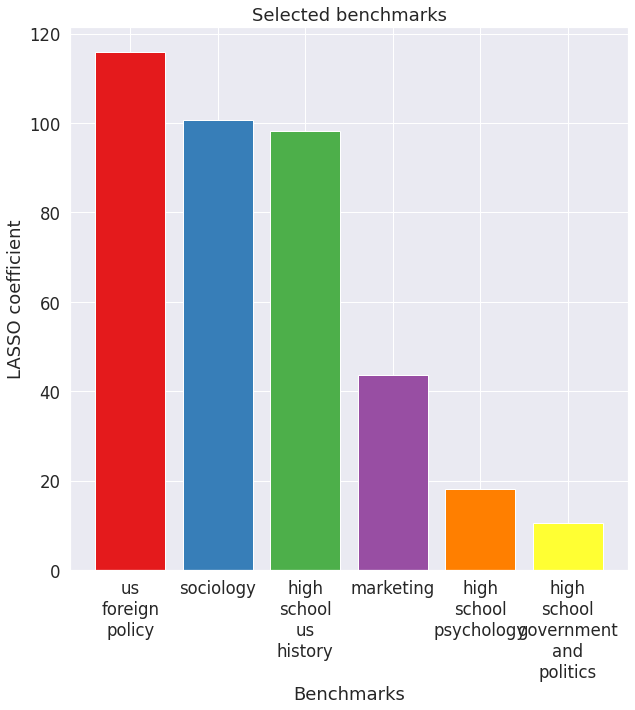

In [29]:
# Plot selected benchmarks
plt.title('Selected benchmarks')
# plt.xticks(rotation=30)
plt.xlabel('Benchmarks')
plt.ylabel('LASSO coefficient')
for i, benchmark in enumerate(selected_benchmarks.keys()):
    plt.bar(benchmark.split('|')[1].replace("hendrycksTest-", "").replace("_", "\n"), selected_benchmarks[benchmark], color=plt.cm.Set1(i))
plt.savefig('assets/selected_benchmarks.png')
plt.show()

In [30]:
# Check Spearman correlation between elo and each benchmark

elo_scores = []
benchmark_scores = []
for i in idx[int(0.8 * len(X)):]:
    model = list(filtered_hf_models.keys())[i]
    elo_scores.append(elo.loc[model]['rating'])
    benchmark_score = 0
    for benchmark in selected_benchmarks.keys():
        result = filtered_hf_models[model]['results'][benchmark]
        if 'acc_norm' in result:
            benchmark_score += result['acc_norm'] * selected_benchmarks[benchmark]
        elif 'mc2' in result:
            benchmark_score += result['mc2'] * selected_benchmarks[benchmark]
    benchmark_scores.append(benchmark_score)
corr = spearmanr(elo_scores, benchmark_scores).correlation

print(corr)

0.942857142857143
